## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from numpy import arange
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns

## Gerando Dataset Desbalanceado para Classificação

In [2]:
# Gerando dataset desbalanceado com 95% y=0 e 5% y=1 
X, y = make_classification(n_samples=10000, n_features=30, n_informative=25, n_redundant=5, 
                           n_clusters_per_class=1, weights=[0.95], flip_y=0, random_state=42)
dataset = pd.DataFrame(X)
dataset['y'] = y
dataset['y'].value_counts(True)

0    0.95
1    0.05
Name: y, dtype: float64

### Partição treino/validação/teste

In [3]:
X_train, X_, y_train, y_ = train_test_split(X, y, random_state=42, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, random_state=42, test_size=0.5)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(7000, 30)
(1500, 30)
(1500, 30)


## Implementando Algoritmo de Árvore de Decisão

### Modelo default

In [4]:
model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

prob_train = model.predict_proba(X_train)[:, 1]
prob_val = model.predict_proba(X_val)[:, 1]
prob_test = model.predict_proba(X_test)[:, 1]
print(f"AUC train: {metrics.roc_auc_score(y_train, prob_train)}")
print(f"AUC val: {metrics.roc_auc_score(y_val, prob_val)}")
print(f"AUC test: {metrics.roc_auc_score(y_test, prob_test)}")

AUC train: 1.0
AUC val: 0.7673152796843652
AUC test: 0.7590616523964595


Matriz de confusão validação:



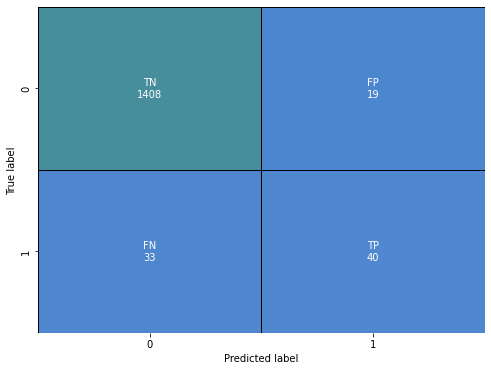

Precisão: 0.6779661016949152
Recall: 0.547945205479452
f1: 0.6060606060606061

---------------------------------------------------------

Matriz de confusão teste:



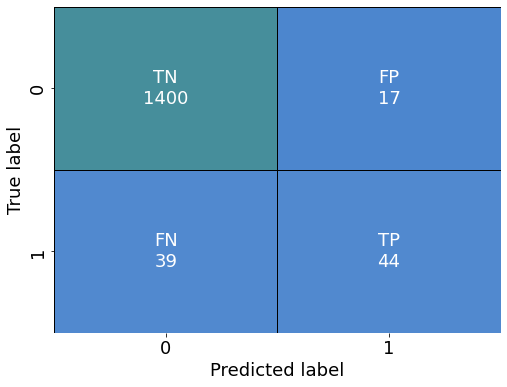

Precisão: 0.7213114754098361
Recall: 0.5301204819277109
f1: 0.6111111111111112


In [5]:
# Função para plot da matriz de confusão
def matriz_confusao(confusion):
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(8,6))
    cmap = sns.diverging_palette(250, 210, l=55, as_cmap=True)
    sns.heatmap(confusion, annot=labels, fmt='', cmap=cmap, cbar=False, linecolor='black', linewidths=1.0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.rcParams.update({'font.size': 18})
    return plt.show()

# Matrizes de confusão e métricas para validação e teste com ponto de corte = 0,5
pred_val = (model.predict_proba(X_val)[:,1] >= 0.5).astype(bool)
confusion_val = confusion_matrix(y_val, pred_val)
print(f"Matriz de confusão validação:\n")
matriz_confusao(confusion_val)
precision_val = precision_score(y_val, pred_val, average='binary')
recall_val = recall_score(y_val, pred_val, average='binary')
f1_val = f1_score(y_val, pred_val, average='binary')
print(f"Precisão: {precision_val}")
print(f"Recall: {recall_val}")
print(f"f1: {f1_val}")

print('\n---------------------------------------------------------\n')

pred_test = (model.predict_proba(X_test)[:,1] >= 0.5).astype(bool)
confusion_test = confusion_matrix(y_test, pred_test)
print(f"Matriz de confusão teste:\n")
matriz_confusao(confusion_test)
precision_test = precision_score(y_test, pred_test, average='binary')
recall_test = recall_score(y_test, pred_test, average='binary')
f1_test = f1_score(y_test, pred_test, average='binary')
print(f"Precisão: {precision_test}")
print(f"Recall: {recall_test}")
print(f"f1: {f1_test}")

In [6]:
pred_test = (model.predict_proba(X_test)[:,1] >= 0.5).astype(bool)
confusion_test = confusion_matrix(y_test, pred_test)
print(f"Matriz de confusão:\n{(confusion_test)}")

Matriz de confusão:
[[1400   17]
 [  39   44]]


### Hyperparameters Tuning

In [7]:
# Parâmetros para tunning
params = {'criterion' :['gini', 'entropy'],
         'splitter': ['best', 'random'],
         'max_features': ['auto', 'sqrt', 'log2'],
         'ccp_alpha': [0, 0.1, 0.01, 0.001],
         'max_depth' : range(2, 102, 2),
         'min_samples_leaf': range(2, 102, 2),
        }

# Definição do cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Busca dos parâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(model, params, n_iter=1000, scoring='roc_auc', verbose=1, n_jobs=-1, cv=cv, random_state=42)
result = random_search.fit(X_train, y_train)
print(f"Best params: {result.best_params_}")
print(f"Best score: {result.best_score_}")

Fitting 30 folds for each of 1000 candidates, totalling 30000 fits
Best params: {'splitter': 'best', 'min_samples_leaf': 52, 'max_features': 'auto', 'max_depth': 18, 'criterion': 'entropy', 'ccp_alpha': 0.001}
Best score: 0.8898868113074215


In [8]:
# summarize result
print(f'Best Score: {result.best_score_}')
print(f'Best Hyperparameters: {result.best_params_}')

Best Score: 0.8898868113074215
Best Hyperparameters: {'splitter': 'best', 'min_samples_leaf': 52, 'max_features': 'auto', 'max_depth': 18, 'criterion': 'entropy', 'ccp_alpha': 0.001}


In [9]:
model_dtt = DecisionTreeClassifier(**result.best_params_, random_state=42).fit(X_train, y_train)

prob_train = model_dtt.predict_proba(X_train)[:, 1]
prob_val = model_dtt.predict_proba(X_val)[:, 1]
prob_test = model_dtt.predict_proba(X_test)[:, 1]
print(f"AUC train: {metrics.roc_auc_score(y_train, prob_train)}")
print(f"AUC val: {metrics.roc_auc_score(y_val, prob_val)}")
print(f"AUC test: {metrics.roc_auc_score(y_test, prob_test)}")

AUC train: 0.9532420477415027
AUC val: 0.8370947768572827
AUC test: 0.8630952887059885


Matriz de confusão validação:



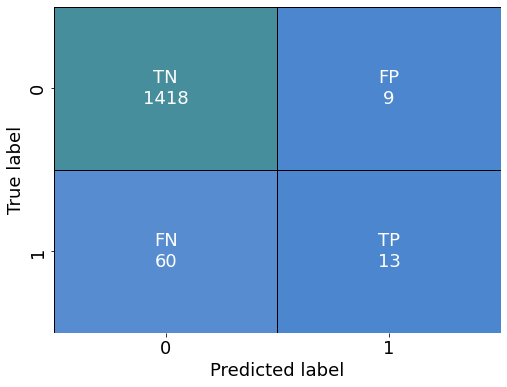

Precisão: 0.5909090909090909
Recall: 0.1780821917808219
f1: 0.2736842105263158

---------------------------------------------------------

Matriz de confusão teste:



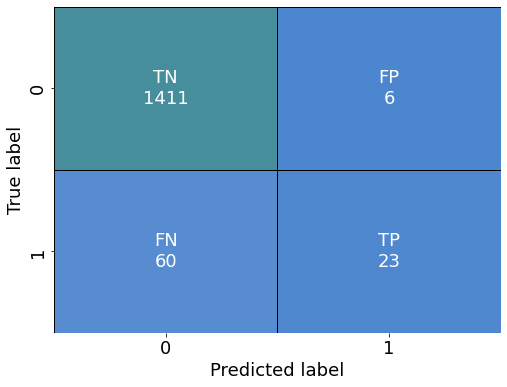

Precisão: 0.7931034482758621
Recall: 0.27710843373493976
f1: 0.41071428571428575


In [10]:
# Matrizes de confusão e métricas para validação e teste com ponto de corte = 0,5
pred_val = (model_dtt.predict_proba(X_val)[:,1] >= 0.5).astype(bool)
confusion_val = confusion_matrix(y_val, pred_val)
print(f"Matriz de confusão validação:\n")
matriz_confusao(confusion_val)
precision_val = precision_score(y_val, pred_val, average='binary')
recall_val = recall_score(y_val, pred_val, average='binary')
f1_val = f1_score(y_val, pred_val, average='binary')
print(f"Precisão: {precision_val}")
print(f"Recall: {recall_val}")
print(f"f1: {f1_val}")

print('\n---------------------------------------------------------\n')

pred_test = (model_dtt.predict_proba(X_test)[:,1] >= 0.5).astype(bool)
confusion_test = confusion_matrix(y_test, pred_test)
print(f"Matriz de confusão teste:\n")
matriz_confusao(confusion_test)
precision_test = precision_score(y_test, pred_test, average='binary')
recall_test = recall_score(y_test, pred_test, average='binary')
f1_test = f1_score(y_test, pred_test, average='binary')
print(f"Precisão: {precision_test}")
print(f"Recall: {recall_test}")
print(f"f1: {f1_test}")

## Implementação do método Bagging

In [11]:
model_bg = BaggingClassifier(model_dtt).fit(X_train, y_train)

prob_train = model_bg.predict_proba(X_train)[:, 1]
prob_val = model_bg.predict_proba(X_val)[:, 1]
prob_test = model_bg.predict_proba(X_test)[:, 1]
print(f"AUC train: {metrics.roc_auc_score(y_train, prob_train)}")
print(f"AUC val: {metrics.roc_auc_score(y_val, prob_val)}")
print(f"AUC test: {metrics.roc_auc_score(y_test, prob_test)}")

AUC train: 0.9894421190183363
AUC val: 0.953480335218055
AUC test: 0.9690335087704381


Matriz de confusão validação:



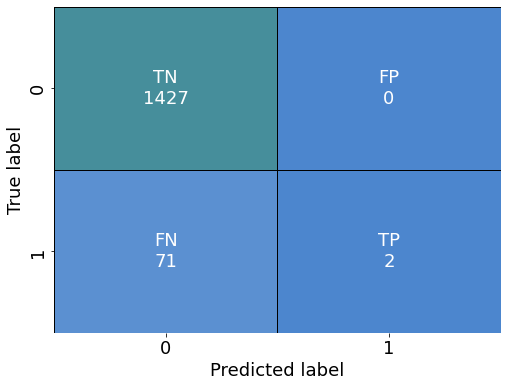

Precisão: 1.0
Recall: 0.0273972602739726
f1: 0.05333333333333332

---------------------------------------------------------

Matriz de confusão teste:



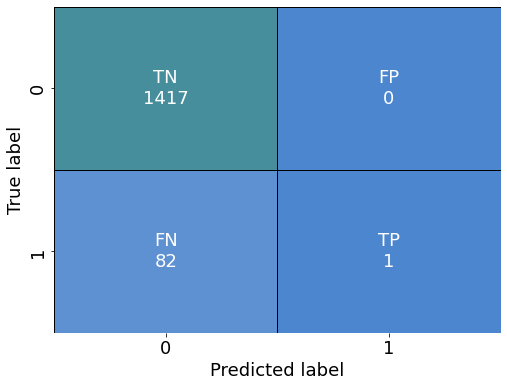

Precisão: 1.0
Recall: 0.012048192771084338
f1: 0.02380952380952381


In [12]:
# Matrizes de confusão e métricas para validação e teste com ponto de corte = 0,5
pred_val = (model_bg.predict_proba(X_val)[:,1] >= 0.5).astype(bool)
confusion_val = confusion_matrix(y_val, pred_val)
print(f"Matriz de confusão validação:\n")
matriz_confusao(confusion_val)
precision_val = precision_score(y_val, pred_val, average='binary')
recall_val = recall_score(y_val, pred_val, average='binary')
f1_val = f1_score(y_val, pred_val, average='binary')
print(f"Precisão: {precision_val}")
print(f"Recall: {recall_val}")
print(f"f1: {f1_val}")

print('\n---------------------------------------------------------\n')

pred_test = (model_bg.predict_proba(X_test)[:,1] >= 0.5).astype(bool)
confusion_test = confusion_matrix(y_test, pred_test)
print(f"Matriz de confusão teste:\n")
matriz_confusao(confusion_test)
precision_test = precision_score(y_test, pred_test, average='binary')
recall_test = recall_score(y_test, pred_test, average='binary')
f1_test = f1_score(y_test, pred_test, average='binary')
print(f"Precisão: {precision_test}")
print(f"Recall: {recall_test}")
print(f"f1: {f1_test}")

## Implementação do método Imbalanced Bagging

In [13]:
model_ib = BalancedBaggingClassifier(model_dtt, random_state=42).fit(X_train, y_train)

prob_train = model_ib.predict_proba(X_train)[:, 1]
prob_val = model_ib.predict_proba(X_val)[:, 1]
prob_test = model_ib.predict_proba(X_test)[:, 1]
print(f"AUC train: {metrics.roc_auc_score(y_train, prob_train)}")
print(f"AUC val: {metrics.roc_auc_score(y_val, prob_val)}")
print(f"AUC test: {metrics.roc_auc_score(y_test, prob_test)}")

AUC train: 0.9743667629835644
AUC val: 0.9604496452947557
AUC test: 0.9584392616336906


Matriz de confusão validação:



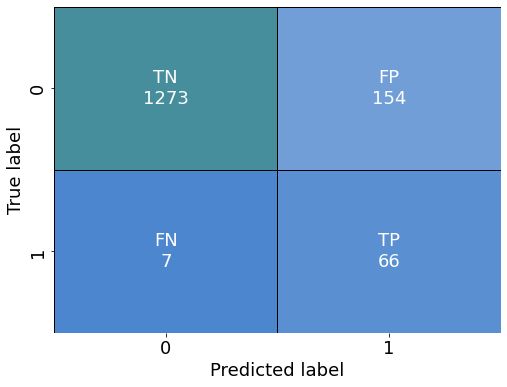

Precisão: 0.3
Recall: 0.9041095890410958
f1: 0.4505119453924915

---------------------------------------------------------

Matriz de confusão teste:



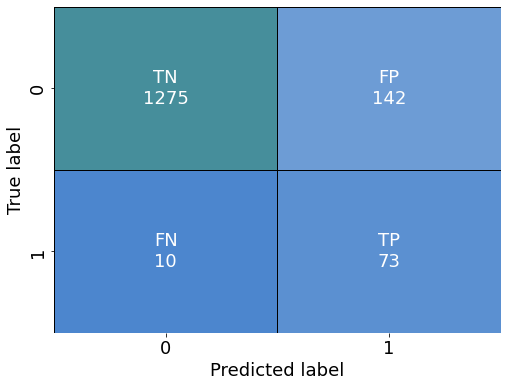

Precisão: 0.3395348837209302
Recall: 0.8795180722891566
f1: 0.4899328859060403


In [14]:
# Matrizes de confusão e métricas para validação e teste com ponto de corte = 0,5
pred_val = (model_ib.predict_proba(X_val)[:,1] >= 0.5).astype(bool)
confusion_val = confusion_matrix(y_val, pred_val)
print(f"Matriz de confusão validação:\n")
matriz_confusao(confusion_val)
precision_val = precision_score(y_val, pred_val, average='binary')
recall_val = recall_score(y_val, pred_val, average='binary')
f1_val = f1_score(y_val, pred_val, average='binary')
print(f"Precisão: {precision_val}")
print(f"Recall: {recall_val}")
print(f"f1: {f1_val}")

print('\n---------------------------------------------------------\n')

pred_test = (model_ib.predict_proba(X_test)[:,1] >= 0.5).astype(bool)
confusion_test = confusion_matrix(y_test, pred_test)
print(f"Matriz de confusão teste:\n")
matriz_confusao(confusion_test)
precision_test = precision_score(y_test, pred_test, average='binary')
recall_test = recall_score(y_test, pred_test, average='binary')
f1_test = f1_score(y_test, pred_test, average='binary')
print(f"Precisão: {precision_test}")
print(f"Recall: {recall_test}")
print(f"f1: {f1_test}")

### Imbalanced Bagging Hyperparameters Tuning

In [15]:
params = {'n_estimators' :[10, 50, 100, 500, 1000],
          'max_samples': arange(0.1, 1.1, 0.1),
          'bootstrap': [False, True],
          'warm_start': [False, True],
          }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
random_search = RandomizedSearchCV(model_ib, params, n_iter=30, scoring='roc_auc', verbose=1, n_jobs=-1, cv=cv, random_state=42)
result = random_search.fit(X_train, y_train)
print(f"Best params: {result.best_params_}")
print(f"Best score: {result.best_score_}")

Fitting 15 folds for each of 30 candidates, totalling 450 fits
Best params: {'warm_start': False, 'n_estimators': 500, 'max_samples': 0.9, 'bootstrap': True}
Best score: 0.9700642670134437


In [16]:
model_ibt = BalancedBaggingClassifier(**result.best_params_, random_state=42).fit(X_train, y_train)

prob_train = model_ibt.predict_proba(X_train)[:, 1]
prob_val = model_ibt.predict_proba(X_val)[:, 1]
prob_test = model_ibt.predict_proba(X_test)[:, 1]
print(f"AUC train: {metrics.roc_auc_score(y_train, prob_train)}")
print(f"AUC val: {metrics.roc_auc_score(y_val, prob_val)}")
print(f"AUC test: {metrics.roc_auc_score(y_test, prob_test)}")

AUC train: 0.9999510845259392
AUC val: 0.9896180318898733
AUC test: 0.9938823749479215


Matriz de confusão validação:



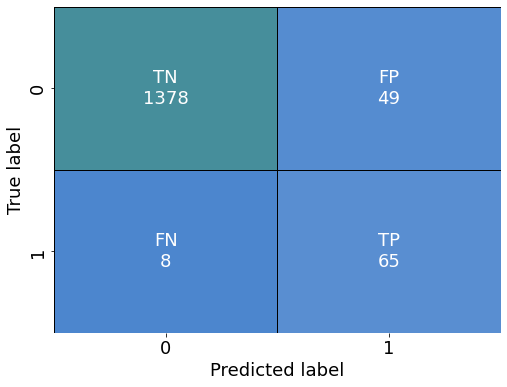

Precisão: 0.5701754385964912
Recall: 0.8904109589041096
f1: 0.6951871657754011

---------------------------------------------------------

Matriz de confusão teste:



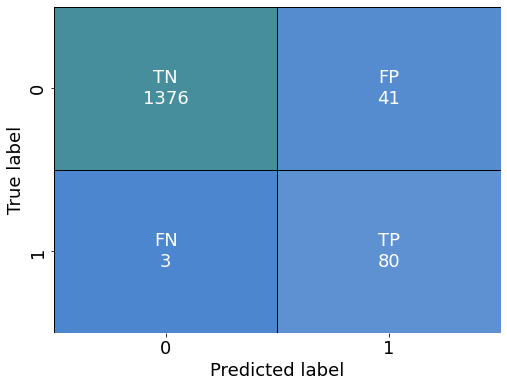

Precisão: 0.6611570247933884
Recall: 0.963855421686747
f1: 0.7843137254901961


In [17]:
# Matrizes de confusão e métricas para validação e teste com ponto de corte = 0,5
pred_val = (model_ibt.predict_proba(X_val)[:,1] >= 0.5).astype(bool)
confusion_val = confusion_matrix(y_val, pred_val)
print(f"Matriz de confusão validação:\n")
matriz_confusao(confusion_val)
precision_val = precision_score(y_val, pred_val, average='binary')
recall_val = recall_score(y_val, pred_val, average='binary')
f1_val = f1_score(y_val, pred_val, average='binary')
print(f"Precisão: {precision_val}")
print(f"Recall: {recall_val}")
print(f"f1: {f1_val}")

print('\n---------------------------------------------------------\n')

pred_test = (model_ibt.predict_proba(X_test)[:,1] >= 0.5).astype(bool)
confusion_test = confusion_matrix(y_test, pred_test)
print(f"Matriz de confusão teste:\n")
matriz_confusao(confusion_test)
precision_test = precision_score(y_test, pred_test, average='binary')
recall_test = recall_score(y_test, pred_test, average='binary')
f1_test = f1_score(y_test, pred_test, average='binary')
print(f"Precisão: {precision_test}")
print(f"Recall: {recall_test}")
print(f"f1: {f1_test}")